---

# Ансамбли моделей

В этой работе мы рассмотрим применение некоторых классических и хорошо себя показавших алгоритмов-ансамблей. Демонстрировать работу этих алгоритмов будем на данных о потреблении электричества.

# Описание набора данных

**Author**: M. Harries, J. Gama, A. Bifet  
**Source**: [Joao Gama](http://www.inescporto.pt/~jgama/ales/ales_5.html) - 2009  
**Please cite**: None  

**Electricity** is a widely used dataset described by M. Harries and analyzed by J. Gama (see papers below). This data was collected from the Australian New South Wales Electricity Market. In this market, prices are not fixed and are affected by demand and supply of the market. They are set every five minutes. Electricity transfers to/from the neighboring state of Victoria were done to alleviate fluctuations.

The dataset (originally named ELEC2) contains 45,312 instances dated from 7 May 1996 to 5 December 1998. Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states and the class label. The class label identifies the change of the price (UP or DOWN) in New South Wales relative to a moving average of the last 24 hours (and removes the impact of longer term price trends). 

The data was normalized by A. Bifet.

### Attribute information  
* Date: date between 7 May 1996 to 5 December 1998. Here normalized between 0 and 1
* Day: day of the week (1-7)
* Period: time of the measurement (1-48) in half hour intervals over 24 hours. Here normalized between 0 and 1
* NSWprice: New South Wales electricity price, normalized between 0 and 1
* NSWdemand: New South Wales electricity demand, normalized between 0 and 1
* VICprice: Victoria electricity price, normalized between 0 and 1
* VICdemand: Victoria electricity demand, normalized between 0 and 1
* transfer: scheduled electricity transfer between both states, normalized between 0 and 1

### Relevant papers  
M. Harries. Splice-2 comparative evaluation: Electricity pricing. Technical report, The University of South Wales, 1999.  
J. Gama, P. Medas, G. Castillo, and P. Rodrigues. Learning with drift detection. In SBIA Brazilian Symposium on Artificial Intelligence, pages 286–295, 2004.

# Разведочный анализ данных

Считайте набор данных в датафрейм

In [20]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

df = pd.read_csv('electricity_train.csv')
df.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.425556,6,0.723404,0.076258,0.311366,0.003467,0.422915,0.414912,1
1,0.867351,7,0.808511,0.028131,0.299018,0.001838,0.325738,0.832018,0
2,0.031680,1,0.723404,0.055242,0.398691,0.003467,0.422915,0.414912,0
3,0.867793,3,1.000000,0.028822,0.396162,0.001014,0.394873,0.639474,0
4,0.880536,4,0.978723,0.040741,0.468908,0.002655,0.425427,0.630702,1


При помощи метода <code>.describe()</code> изучите набор данных «с высоты птичьего полета».

In [4]:
df.describe()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
count,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000
mean,0.498293,4.006566,0.500560,0.057828,0.425939,0.003455,0.423024,0.500243,0.424536
std,0.339907,1.993551,0.294998,0.039052,0.163390,0.010175,0.120600,0.153098,0.494279
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031945,2.000000,0.255319,0.035187,0.309729,0.002283,0.373382,0.414912,0.000000
50%,0.456263,4.000000,0.510638,0.048787,0.444213,0.003467,0.422915,0.414912,0.000000
75%,0.880492,6.000000,0.765957,0.074457,0.536745,0.003467,0.468669,0.605263,1.000000
max,1.000000,7.000000,1.000000,1.000000,0.980809,1.000000,1.000000,0.959211,1.000000


Убедитесь в отсутствии пропусков. Имеет смысл проверить сбалансированность классов. Введите долю элементов класса $1$.

date         0
day          0
period       0
nswprice     0
nswdemand    0
vicprice     0
vicdemand    0
transfer     0
class        0
dtype: int64
0.4245358492648073


<Axes: xlabel='class', ylabel='Count'>

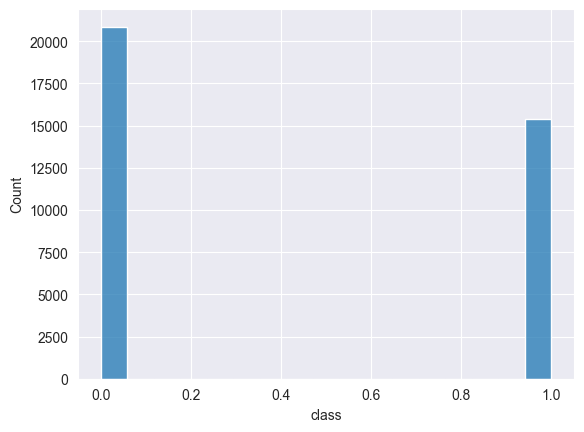

In [21]:
print(df.isna().sum())
print(df['class'].value_counts()[1]/(df['class'].value_counts()[1]+df['class'].value_counts()[0]))
sns.histplot(df['class'])

Постройте матрицу корреляций. Определите пару наиболее коррелированных признаков.

In [16]:
class_distribution = df.value_counts(normalize=True)
print(class_distribution)

date      day  period    nswprice  nswdemand  vicprice  vicdemand  transfer  class
0.000000  2    0.000000  0.056443  0.439155   0.003467  0.422915   0.414912  1        0.000028
0.867882  5    0.468085  0.029873  0.616334   0.001921  0.725272   0.445175  1        0.000028
               0.234043  0.029062  0.343796   0.001703  0.356033   0.692105  1        0.000028
               0.276596  0.028402  0.433204   0.001824  0.523822   0.605702  0        0.000028
               0.297872  0.028131  0.472032   0.001803  0.526670   0.603947  0        0.000028
                                                                                        ...   
0.434007  7    0.595745  0.061307  0.286522   0.003467  0.422915   0.414912  1        0.000028
               0.574468  0.061307  0.287861   0.003467  0.422915   0.414912  1        0.000028
               0.510638  0.061307  0.309134   0.003467  0.422915   0.414912  1        0.000028
               0.446809  0.067581  0.329961   0.003467  0.4229

Постройте гистограммы распределений признаков.

In [7]:
correlation_matrix = df.corr()
print(correlation_matrix)

               date       day    period  nswprice  nswdemand  vicprice  \
date       1.000000  0.005840  0.001577 -0.153561   0.067692  0.002110   
day        0.005840  1.000000 -0.000416  0.003168  -0.052946  0.001082   
period     0.001577 -0.000416  1.000000  0.105341   0.444579  0.022706   
nswprice  -0.153561  0.003168  0.105341  1.000000   0.306982  0.288349   
nswdemand  0.067692 -0.052946  0.444579  0.306982   1.000000  0.083510   
vicprice   0.002110  0.001082  0.022706  0.288349   0.083510  1.000000   
vicdemand  0.057239  0.076904  0.192153  0.304492   0.667174  0.125489   
transfer   0.405853 -0.053012 -0.115437 -0.274764  -0.264476 -0.081112   
class     -0.003827 -0.046841  0.154224  0.386071   0.331741  0.065630   

           vicdemand  transfer     class  
date        0.057239  0.405853 -0.003827  
day         0.076904 -0.053012 -0.046841  
period      0.192153 -0.115437  0.154224  
nswprice    0.304492 -0.274764  0.386071  
nswdemand   0.667174 -0.264476  0.331741  
v

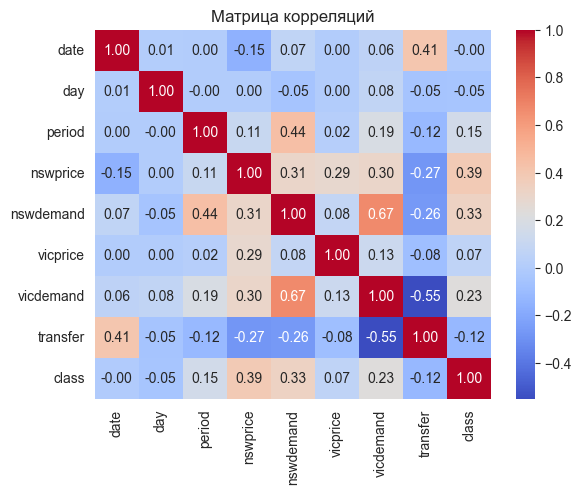

In [9]:
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

In [15]:
correlation_pairs = correlation_matrix.unstack().sort_values(ascending=False)
# Убираем самосвязи (корреляция 1)
correlation_pairs = correlation_pairs[correlation_pairs < 1]
most_correlated = correlation_pairs.idxmax()  # Пара с максимальной корреляцией
print(f'Наиболее коррелированные переменные: {most_correlated[0]}, {most_correlated[1]}')

Наиболее коррелированные переменные: vicdemand, nswdemand


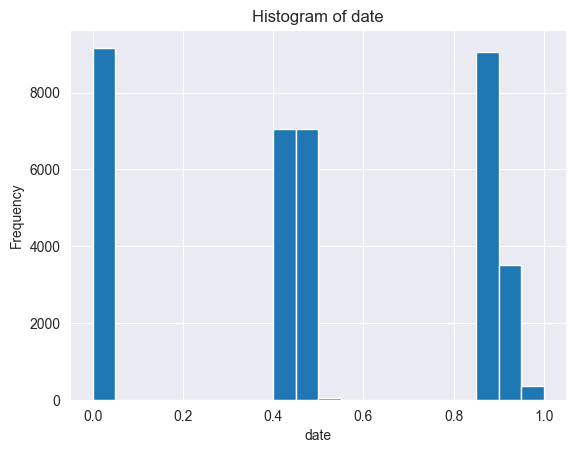

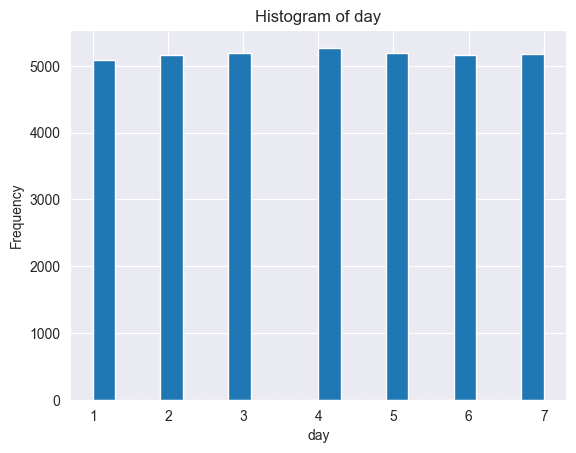

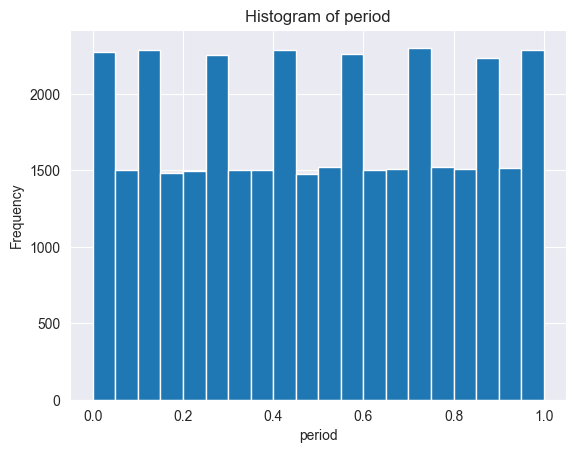

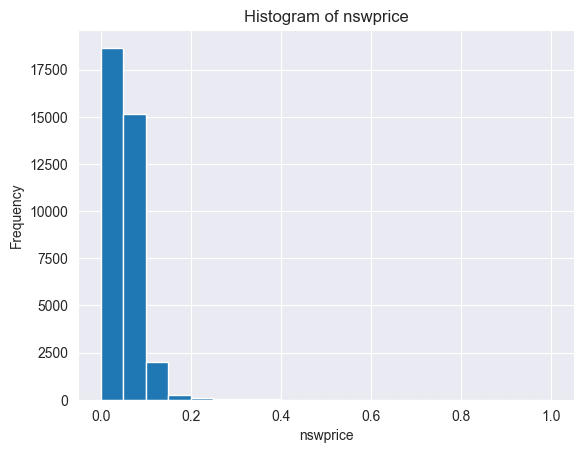

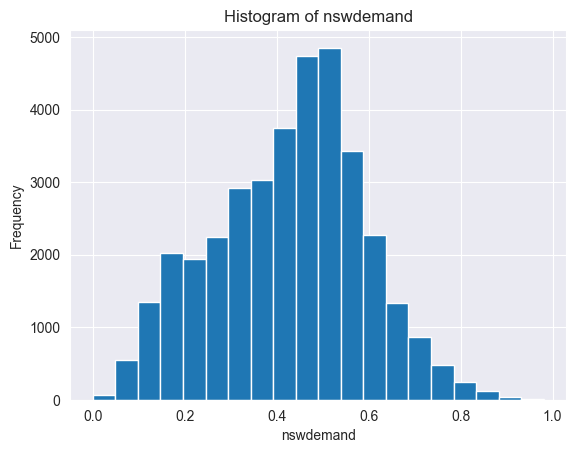

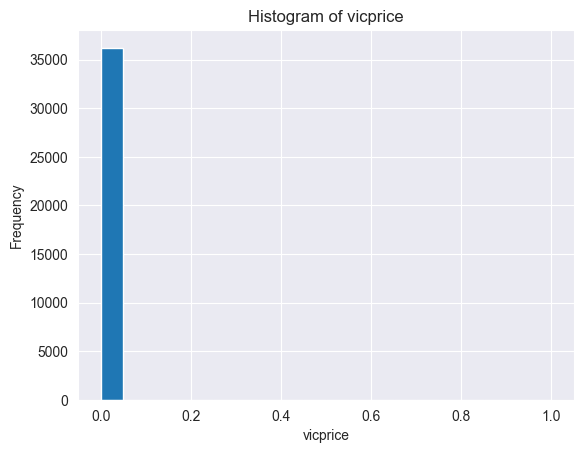

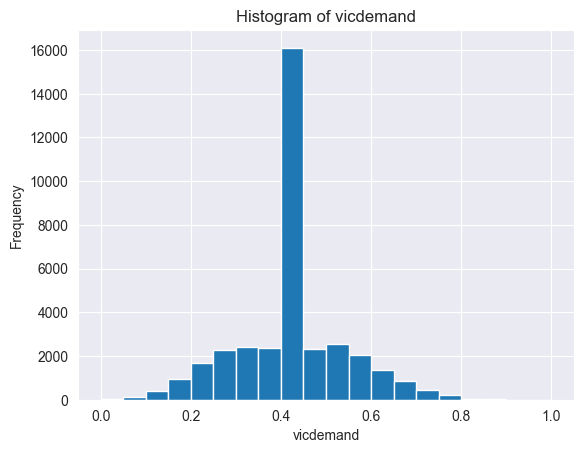

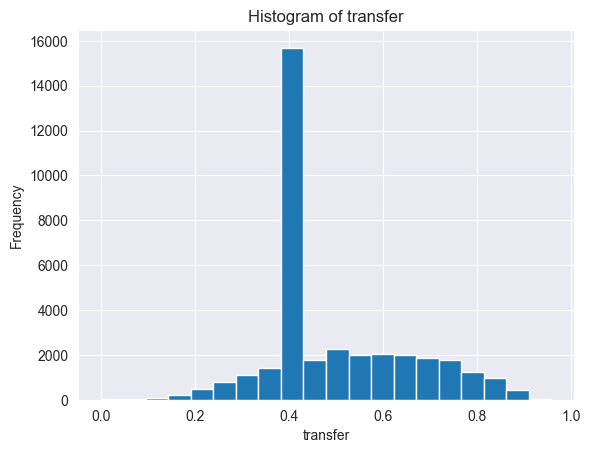

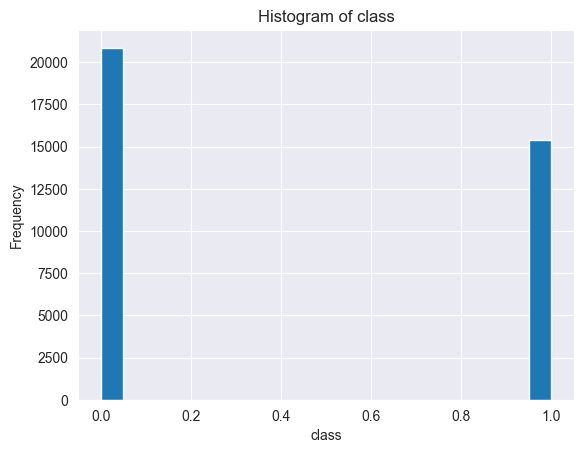

In [10]:
for column in df.columns:
    plt.hist(df[column], bins=20)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

Из полученных иллюстраций видно, что в данных, скорее всего, как и ожидалось, есть некоторая периодичность. Более того, похоже, за нас уже поработали над заполнением пропусков или обработкой выбросов

При помощи <code>train_test_split</code> разобейте полученный набор данных на тренеровочную и тестовую выборки с параметрами, указанными в вашем варианте.

In [ ]:
# < ENTER YOUR CODE HERE > 

# Random Forests Classifier

Обучите модель <code>sklearn.ensemble.RandomForestClassifier</code> на тренировочных данных с параметрами, указанными в вашем индивидуальном задании. 

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Загрузка данных (замените 'your_dataset.csv' на ваш файл)
data = df

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df, test_size=0.2, random_state=7)

# Создание и обучение модели Random Forest
model = RandomForestClassifier(random_state=7)
model.fit(X_train, y_train)

# Прогнозирование на тренировочных данных
y_train_pred = model.predict(X_train)

# Генерация отчета о классификации
report = classification_report(y_train, y_train_pred, digits=4)
print("Classification Report:\n", report)

# Вычисление точности модели на тренировочных данных
accuracy = accuracy_score(y_train, y_train_pred)
print(f"Accuracy on training data: {accuracy:.4f}")

ValueError: not enough values to unpack (expected 4, got 2)

Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [ ]:
# < ENTER YOUR CODE HERE > 

Получили переобучение. Что же, еще раз можно ответить, что деревья принятия решений весьма склонны к переобучению.

## Добавление к лесу деревьев GridSearchCV

При помощи <code>sklearn.model_selection.GridSearchCV</code> обучите <code>RandomForestClassifier</code> на тренировочных данных c параметрами, указанными в вашем индивидуальном задании. 

Подбираемые параметры: 

<code>{'n_estimators': [100,300,500], 'max_leaf_nodes': list(range(6,10)), 'min_samples_leaf': [1,2,3]}</code>

In [ ]:
# < ENTER YOUR CODE HERE > 

Выберите лучшую модель. Рекомендуем использовать поле <code>best_estimator_</code> объекта класса <code>grid_search</code>. В поле <code>best_params_</code> этого же объекта можно найти параметры лучшей модели. 

In [ ]:
# < ENTER YOUR CODE HERE > 

Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [ ]:
# < ENTER YOUR CODE HERE > 

Постройте <code>classification_report</code> полученной модели на **тестовых данных**. Введите значение точности модели на **тестовых данных**.

In [ ]:
# < ENTER YOUR CODE HERE > 

От переобучения избавились, но точность кажется низкой.

Один из плюсов случайного леса — можно посмотреть на важность признаков при классификации (обратная задача). Значения важности можно найти в поле <code>feature_importances_</code> модели. Определите название самого важного признака модели.

In [ ]:
# < ENTER YOUR CODE HERE > 

Попробуем улучшить результаты, используя другие виды ансамблей.

# Voting Classifier

Обучает все модели, поданные на вход, и предсказывает финальный результат либо по большему числу одинаковых ответов, которые дали модели (hard), либо вычисляет вероятность отнесения объектов к классам по всем моделям и берет argmax.

Используйте объект <code>sklearn.ensemble.VotingClassifier</code> с параметром <code>voting='hard'</code>. В качестве базовых алгоритмов используйте классификаторы с соответствующими параметрами, указанными в вашем индивидуальном задании. Обучите модель на тренировочных данных

In [ ]:
# < ENTER YOUR CODE HERE > 

Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE > 

Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE > 

# Bagging Classifier

Создает несколько объектов одного класса (несколько моделей) и обучает их на непересекающихся подмножествах тренировочных данных, а дальше усредняет ответы.

На основе <code>sklearn.ensemble.BaggingClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [ ]:
# < ENTER YOUR CODE HERE > 

Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE > 

Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE > 

# Gradient Boosting Classifier

Градиентный бустинг работает примерно так: создается несколько объектов класса (несколько моделей), они выстраиваются в цепочку так, чтобы каждый следующий пытался исправить ошибки предыдущего. Склонен к переобучению.

Обучите модель на основе <code>sklearn.ensemble.GradientBoostingClassifier</code> с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [ ]:
# < ENTER YOUR CODE HERE > 

Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE > 

Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE > 

# AdaBoost Classifier

Работает похожим на градиентный бустинг образом, только последующие модели не пытаются исправить ошибку предыдущих: сначала первый объект обучается на всем датасете, а следующий на основе опыта предыдущего обновляет свои веса так, чтобы исправлять ошибочные предсказания.

На основе <code>sklearn.ensemble.AdaBoostClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [ ]:
# < ENTER YOUR CODE HERE > 

Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE > 

Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE > 

# Stacking Classifier

Обучает несколько объектов класса (несколько моделей) на всем наборе данных, а после — обучает отдельный классификатор на метданных — ответах, полученных обученными ранее моделями.

Используйте объект <code>sklearn.ensemble.StackingClassifier</code>. Базовые алгоритмы и решающий, а также соответствующие параметры указанны в вашем индивидуальном задании. Обучите модель на тренировочных данных.

In [ ]:
# < ENTER YOUR CODE HERE > 

Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE > 

Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE > 